# **[Week 12] Autoencoder**

In this practice session, we will cover the following:
- Linear autoencoder
- Autoencoder latent space visualization
- Convolutional autoencoder

&nbsp;

**[Important]** The results of exercises should be included in your weekly report for this practice session. The weekly report for this session should be submitted on KLMS by this weekend. No late submission would be accepted.

## 0. Preview


An Autoencoder is an neural network capable of learning a compact representation known as **latent representation** or coding from input data, even without the use of labeled data (i.e., utilizing unlabeled training data).

This coding generally exists in a lower-dimensional space compared to the input, enabling beneficial applications in dimensionality reduction and visualization.

Autoencoders serve as effective **feature extractors** and can be utilized for unsupervised pre-training of deep neural networks.

Moreover, certain autoencoders can generate new data closely resembling the training data, constituting a generative model.

![](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

### To better understand autoencoders, let's first examine how the latent representation is effectively learned through autoencoder.

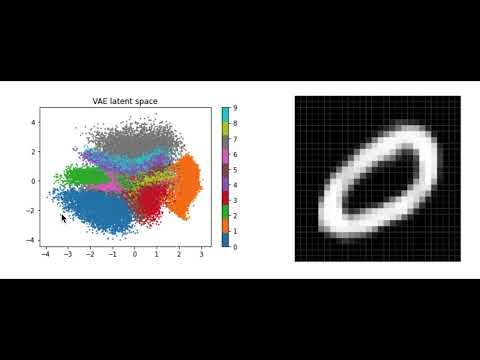

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('cYrl62YxO7c', width=1000, height=412)


`youtube reference: https://www.youtube.com/watch?v=cYrl62YxO7c`

## 1. Preparations

First, we need to import the required packages

In [ ]:
# Import packages
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from sklearn.manifold import TSNE

Then, we will check if GPU is available for use, and fix the seed for random number generation to provide consistent outcomes.

In [ ]:
# Set PyTorch device (use GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# If GPU is available, check CUDA version
if torch.cuda.is_available():
    !nvcc --version

cuda
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
# Set random seeds fixed for reproducibility
seed = 7    # Do NOT change the seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

## 2. MNIST Dataset

We will utilize the MNIST dataset that we covered during the 6th week's practice session to train the autoencoder. MNIST consists of handwritten digits, with 60,000 samples for training and 10,000 samples for evaluation.

In [ ]:
# MNIST Datasets
mnist_train = datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

# Dataloaders
train_batch_size = 20
test_batch_size = 500
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=train_batch_size, shuffle=True, drop_last=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=train_batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 145671148.83it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 22890342.75it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 34819187.09it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6470967.65it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
# Visualize MNIST samples
for i in range(100):
    index = random.randint(0, 50000)
    x_sample, _ = mnist_train[index]
    plt.subplot(10, 10, i+1)
    plt.imshow(x_sample[0], cmap='gray')
    plt.axis('off')

NameError: ignored

## 3. Linear Autoencoder

### 3-1. Define a linear autoencoder model

In [ ]:
# define the autoencoder architecture

# encoder
class Encoder(nn.Module):
    def __init__(self, encoding_dim):
      super().__init__()
      # linear layer (784 -> encoding_dim)
      self.fc1 = nn.Linear(28 * 28, encoding_dim)

    def forward(self, x):
      # add layer, with relu activation function
      return F.relu(self.fc1(x))

# decoder
class Decoder(nn.Module):
    def __init__(self, encoding_dim):
      super().__init__()
      # linear layer (encoding_dim -> input size)
      self.fc2 = nn.Linear(encoding_dim, 28*28)

    def forward(self, x):
      # output layer (sigmoid for scaling from 0 to 1)
      return F.sigmoid(self.fc2(x))

In [ ]:
# combine encoder and decoder
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder(encoding_dim)
        self.decoder = Decoder(encoding_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# initialize the autoencoder
encoding_dim = 32
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (fc2): Linear(in_features=32, out_features=784, bias=True)
  )
)


### 3-2. Define a loss function and an optimizer

In [ ]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 3-3. Train the autoencoder

In [ ]:
# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    for data in dataloaders['train']:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    # print avg training statistics
    train_loss = train_loss/len(dataloaders['train'])
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))

Epoch: 1 	Training Loss: 0.711998
Epoch: 2 	Training Loss: 0.360552
Epoch: 3 	Training Loss: 0.309955
Epoch: 4 	Training Loss: 0.299174
Epoch: 5 	Training Loss: 0.294662
Epoch: 6 	Training Loss: 0.291745
Epoch: 7 	Training Loss: 0.290020
Epoch: 8 	Training Loss: 0.288790
Epoch: 9 	Training Loss: 0.287955
Epoch: 10 	Training Loss: 0.287142
Epoch: 11 	Training Loss: 0.286545
Epoch: 12 	Training Loss: 0.285846
Epoch: 13 	Training Loss: 0.285237
Epoch: 14 	Training Loss: 0.284621
Epoch: 15 	Training Loss: 0.284078
Epoch: 16 	Training Loss: 0.283588
Epoch: 17 	Training Loss: 0.283184
Epoch: 18 	Training Loss: 0.282600
Epoch: 19 	Training Loss: 0.282334
Epoch: 20 	Training Loss: 0.281622


### 3.4. Test the trained autoencodrer

Let's compare the original images with the images reconstructed by the trained linear autoencoder.

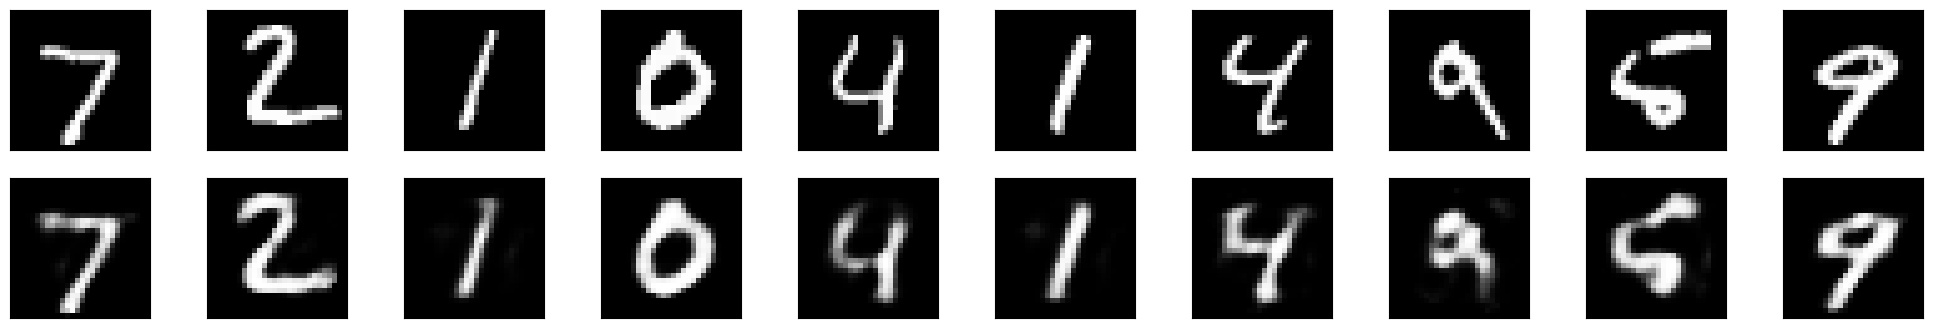

In [ ]:
# obtain one batch of test images
dataiter = iter(dataloaders['test'])
images, labels = next(dataiter)

images_flatten = images.view(images.size(0), -1)
# get sample outputs
output = model(images_flatten)
# prep images for display
images = images.numpy()

# output is resized into a batch of images
output = output.view(test_batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

### 3.5. Visualize the latent representation

And then, let's visualize the latent representation!

&nbsp;

To achieve this, we will first use **t-SNE** (t-distributed Stochastic Neighbor Embedding) to transform the 32-dimensional data into 2-dimensional space. t-SNE is a dimensionality reduction technique that converts high-dimensional data into lower-dimensional space. It excels in visualizing clusters that may exist in the data, as it dramatically represents the positions of data points in high-dimensional space within a lower-dimensional space. It is primarily utilized for visualization purposes.

&nbsp;

Encoded image shape: (500, 32)
Encoded image shape after t-SNE: (500, 2)


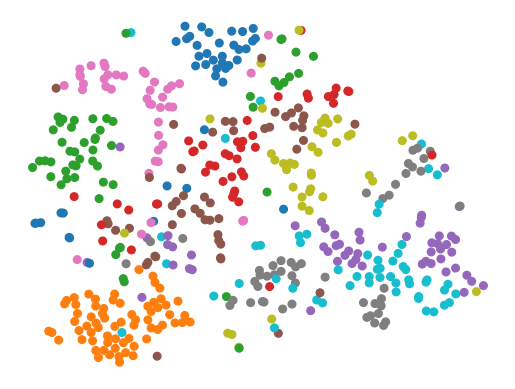

In [ ]:
encoded_imgs = model.encoder(images_flatten).detach().numpy()
print(f'Encoded image shape: {encoded_imgs.shape}')
encoded_imgs_2d = TSNE(n_components = 2).fit_transform(encoded_imgs)
encoded_imgs_2d = (encoded_imgs_2d - encoded_imgs_2d.min()) / (encoded_imgs_2d.max() - encoded_imgs_2d.min())
print(f'Encoded image shape after t-SNE: {encoded_imgs_2d.shape}')
plt.figure()
plt.scatter(encoded_imgs_2d[:,0],encoded_imgs_2d[:,1], c=labels, s=30, cmap='tab10')
plt.axis("off")
plt.show()


To enhance clarity in visualization, it's possible to depict how each encoded image is plotted on the plot.

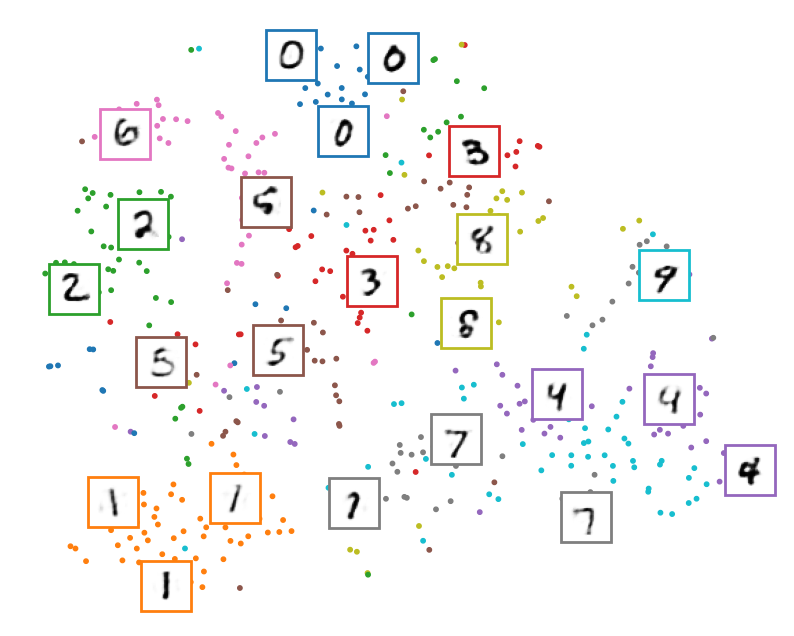

In [ ]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html

test_dataset_array = images / 255
test_dataset_array = np.float32(test_dataset_array)
test_dataset_array = torch.tensor(test_dataset_array)
inputs = test_dataset_array.to(device)

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(encoded_imgs_2d[:, 0], encoded_imgs_2d[:, 1], c=labels, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(encoded_imgs_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(torch.squeeze(inputs).cpu().numpy()[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()


Up until now, we've implemented the autoencoder in a very simple manner, but using learned techniques like convolutional neural networks can lead to improved performance.

## 4. Covolutional AutoEncoder

### 4-1. Define a convolutional autoencoder model

#### **Exercise**. Implement an Encoder and Decoder to have the exact same network structure as shown in the diagram.

<img src="https://drive.google.com/uc?export=view&id=1LTkZgy9zHTuW-ouz-TiD5nAE4d_M9NSJ" width="750" height="210" />


In [ ]:
# encoder
class Encoder(nn.Module):
    def __init__(self):
      super().__init__()

      """ ### Implement the code yourself ### """
      # conv layer (depth from 1 --> 16), 3x3 kernels
      self.conv1 = nn.Conv2d(1,16, kernel_size=3, stride=1, padding=1)
      # conv layer (depth from 16 --> 4), 3x3 kernels
      self.conv2 = nn.Conv2d(16,4, kernel_size=3, stride=1, padding=1)
      # pooling layer to reduce x-y dims by two; kernel and stride of 2
      self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):

      """ ### Implement the code yourself ### """

      x = self.conv1(x)
      x = self.pool(x)
      x = self.conv2(x)
      x = self.pool(x)

      return x

# decoder
class Decoder(nn.Module):
    def __init__(self):
      super().__init__()

      """ ### Implement the code yourself ### """
      # a kernel of 2 and a stride of 2 will increase the spatial dims by 2

      self.conv_to_2d_1 = nn.ConvTranspose2d(4,16,kernel_size=2,stride=2)
      self.conv_to_2d_2 = nn.ConvTranspose2d(16,1,kernel_size=2,stride=2)

    def forward(self, x):

      """ ### Implement the code yourself ### """

      x = self.conv_to_2d_1(x)
      x = self.conv_to_2d_2(x)

      return x

In [ ]:
# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (conv_to_2d_1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (conv_to_2d_2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
  )
)


### 4-2. Define a loss function and an optimizer

In [ ]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 4-3. Train the convolutional autoencoder

In [ ]:
# number of epochs to train the model
n_epochs = 30

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    for data in dataloaders['train']:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    # print avg training statistics
    train_loss = train_loss/len(dataloaders['train'])
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch,
        train_loss
        ))

Epoch: 1 	Training Loss: 0.356191
Epoch: 2 	Training Loss: 0.289249
Epoch: 3 	Training Loss: 0.286474
Epoch: 4 	Training Loss: 0.285134
Epoch: 5 	Training Loss: 0.284356
Epoch: 6 	Training Loss: 0.283748
Epoch: 7 	Training Loss: 0.283127
Epoch: 8 	Training Loss: 0.282368
Epoch: 9 	Training Loss: 0.281858
Epoch: 10 	Training Loss: 0.281338
Epoch: 11 	Training Loss: 0.280906
Epoch: 12 	Training Loss: 0.280569
Epoch: 13 	Training Loss: 0.280103
Epoch: 14 	Training Loss: 0.279778
Epoch: 15 	Training Loss: 0.279532
Epoch: 16 	Training Loss: 0.279332
Epoch: 17 	Training Loss: 0.279192
Epoch: 18 	Training Loss: 0.279020
Epoch: 19 	Training Loss: 0.278939
Epoch: 20 	Training Loss: 0.278819
Epoch: 21 	Training Loss: 0.278703
Epoch: 22 	Training Loss: 0.278707
Epoch: 23 	Training Loss: 0.278627
Epoch: 24 	Training Loss: 0.278578
Epoch: 25 	Training Loss: 0.278588
Epoch: 26 	Training Loss: 0.278526
Epoch: 27 	Training Loss: 0.278517
Epoch: 28 	Training Loss: 0.278460
Epoch: 29 	Training Loss: 0.2

### 4-4. Test the trained autoencodrer

Now, let's reconstruct images using the autoencoder once again and compare the results with those from the linear autoencoder.

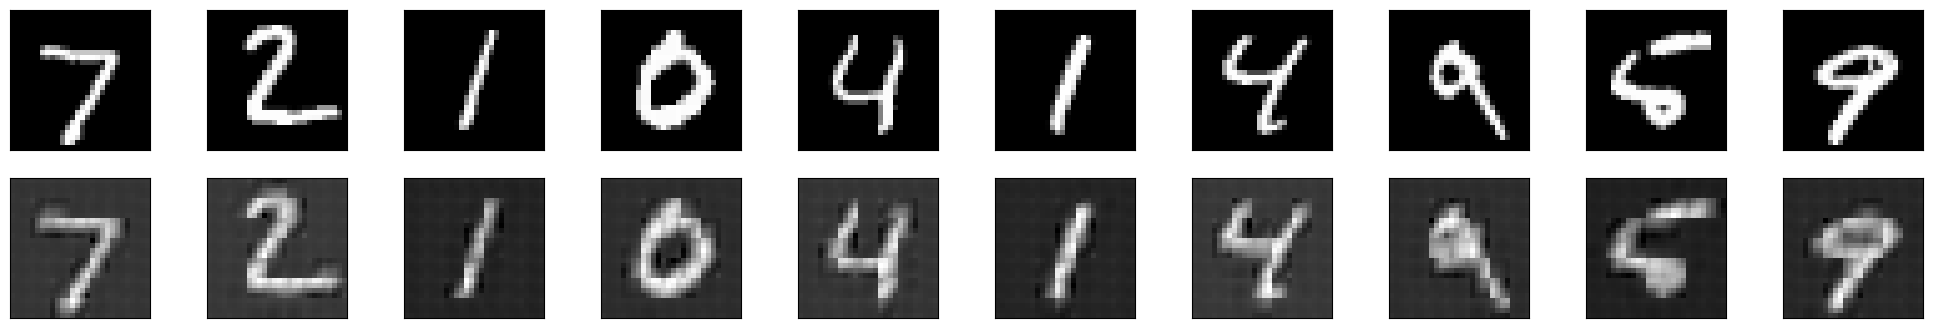

In [ ]:
# obtain one batch of test images
dataiter = iter(dataloaders['test'])
images, labels = next(dataiter)

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(test_batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

## References
  - https://github.com/udacity/deep-learning-v2-pytorch
  - https://blog.keras.io/building-autoencoders-in-keras.html

